Based on DIPY tutorial https://dipy.org/documentation/1.7.0/examples_built/07_reconstruction/reconst_dki/#sphx-glr-examples-built-07-reconstruction-reconst-dki-py

In [1]:
import numpy as np
import dipy.reconst.dki as dki
import dipy.reconst.dti as dti
from dipy.core.gradients import gradient_table
from dipy.data import get_fnames
from dipy.io.gradients import read_bvals_bvecs
from dipy.io.image import load_nifti
from dipy.segment.mask import median_otsu

In [2]:
fraw, fbval, fbvec, t1_fname = get_fnames('cfin_multib')

data, affine = load_nifti(fraw)
bvals, bvecs = read_bvals_bvecs(fbval, fbvec)
gtab = gradient_table(bvals, bvecs)

  0%|          | 0/1409 [00:00<?, ? MB/s]

  0%|          | 0/10603 [00:00<?, ? MB/s]

  0%|          | 0/1 [00:00<?, ? MB/s]

  0%|          | 0/1 [00:00<?, ? MB/s]

In [3]:
maskdata, mask = median_otsu(data, vol_idx=[0, 1], median_radius=4, numpass=2,
                             autocrop=False, dilate=1)

No smoothing or denoising is done to highlight the noise effects.

So let's process the standard diffusion kurtosis metrics

In [4]:
dkimodel = dki.DiffusionKurtosisModel(gtab)
dkif = dkimodel.fit(data, mask=mask)

In [13]:
MK = dkif.mk(0, 10)
RK = dkif.rk(0, 10)
MKT = dkif.mkt(0, 10)

Let's process now the radial tensor kurtosis

In [14]:
from dipy.reconst.dki import split_dki_param, Wrotate_element

def radial_tensor_kurtosis(dki_params, min_kurtosis=-3./7, max_kurtosis=10):
    r""" Compute radial tensor kurtosis (RTK) [1]_

    Parameters
    ----------
    dki_params : ndarray (x, y, z, 27) or (n, 27)
        All parameters estimated from the diffusion kurtosis model.
        Parameters are ordered as follows:
            1) Three diffusion tensor's eigenvalues
            2) Three lines of the eigenvector matrix each containing the first,
               second and third coordinates of the eigenvector
            3) Fifteen elements of the kurtosis tensor
    min_kurtosis : float (optional)
        To keep kurtosis values within a plausible biophysical range, radial
        kurtosis values that are smaller than `min_kurtosis` are replaced with
        `min_kurtosis`. Default = -3./7 (theoretical kurtosis limit for regions
        that consist of water confined to spherical pores [3]_)
    max_kurtosis : float (optional)
        To keep kurtosis values within a plausible biophysical range, radial
        kurtosis values that are larger than `max_kurtosis` are replaced with
        `max_kurtosis`. Default = 10

    Returns
    -------
    rtk : array
        Calculated RK.

    Notes
    -----
    RTK is defined as

    .. math::

    RKT = \frac{3}{8} (W_{2222} + W_{3333} + 2*W_{2233})
    
    where W is the kurtosis tensor rotated to a coordinate system in which the
    3 orthonormal eigenvectors of DT are the base coordinate
    """
    outshape = dki_params.shape[:-1]
    dki_params = dki_params.reshape((-1, dki_params.shape[-1]))

    # Split the model parameters to three variable containing the evals,
    # evecs, and kurtosis elements
    evals, evecs, kt = split_dki_param(dki_params)

    # Rotate the kurtosis tensor from the standard Cartesian coordinate
    # system to another coordinate system in which the 3 orthonormal
    # eigenvectors of DT are the base coordinate
    Wyyyy = Wrotate_element(kt, 1, 1, 1, 1, evecs)
    Wzzzz = Wrotate_element(kt, 2, 2, 2, 2, evecs)
    Wyyzz = Wrotate_element(kt, 1, 1, 2, 2, evecs)

    # Compute RK
    RTK = 3/8 * (Wyyyy +  Wzzzz +  2*Wyyzz)

    if min_kurtosis is not None:
        RTK = RTK.clip(min=min_kurtosis)

    if max_kurtosis is not None:
        RTK = RTK.clip(max=max_kurtosis)

    return RTK.reshape(outshape)

In [32]:
RKT = radial_tensor_kurtosis(dkif.model_params, -100, 1000)

Radial tensor kurtosis estimates are rescaled to minimize the effects from non radial directions (https://pubmed.ncbi.nlm.nih.gov/27539807/) 

In [35]:
MD = dkif.md
RD = dkif.rd
Kper = RKT * MD**2 / (RD**2)
Kper[mask==0] = 0

C:\Users\rafae\AppData\Local\Temp\ipykernel_6188\1376452200.py:3: RuntimeWarning: invalid value encountered in true_divide
  Kper = RKT * MD**2 / (RD**2)


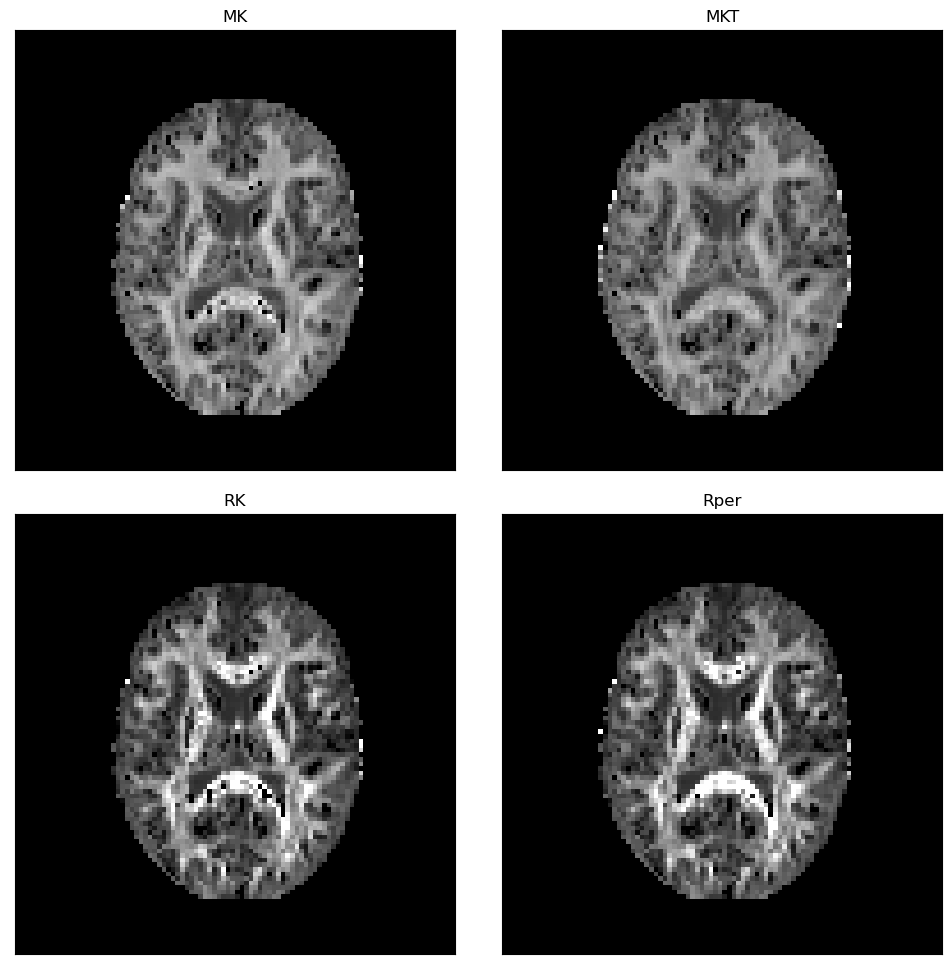

In [42]:
import matplotlib.pyplot as plt

axial_slice = 11

fig1, ax = plt.subplots(2, 2, figsize=(12, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

fig1.subplots_adjust(hspace=0.1, wspace=0.1)

ax.flat[0].imshow(MK[:, :, axial_slice].T, cmap='gray', vmin=0, vmax=1.5,
                  origin='lower')
ax.flat[0].set_title('MK')

ax.flat[1].imshow(MKT[:, :, axial_slice].T, cmap='gray', vmin=0, vmax=1.5,
                  origin='lower')
ax.flat[1].set_title('MKT')

ax.flat[2].imshow(RK[:, :, axial_slice].T, cmap='gray', vmin=0, vmax=2,
                  origin='lower')
ax.flat[2].set_title('RK')

ax.flat[3].imshow(Kper[:, :, axial_slice].T, cmap='gray', vmin=0, vmax=2,
                  origin='lower')
ax.flat[3].set_title('Rper')

plt.show()